In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
# from dask.distributed import LocalCluster
from scipy import interpolate, signal
%matplotlib inline

In [2]:
# client = LocalCluster()
# client

In [3]:
fdir = "D:/crs/proj/2019_DorianOBX/WayneWright_flights/"

fnames = (\
          "post_Matthew_lidar_1m.tif",\
          "2019-08-30_1m_DEM_v1_crop.tif",\
          "2019-09-12-13_DEM_1m_v1_crop.tif")

titles = ([\
         "post-Matthew",\
         "pre-Dorian",\
         "post-Dorian"])

nf = len(fnames)

# optional median-filter smoothing of original maps
smooth = False
# kernal size...this should be an odd number >= dxy/0.1
ksize = 3

In [4]:
def box2UTMh(x, y, x0, y0, theta):
    '''
    2D rotation and translation of x, y
    Input:
        x, y - row vectors of original coordinates (must be same size)
        x0, y0 - Offset (location of x, y = (0,0) in new coordinate system)
        theta - Angle of rotation (degrees, CCW from x-axis == Cartesian coorinates)
    Returns:
        xr, yr - rotated, offset coordinates
    '''
    thetar = np.radians(theta)
    c, s = np.cos(thetar), np.sin(thetar)

    # homogenous rotation matrix
    Rh = np.array(((c, -s,  0.),\
                   (s,  c,  0.),\
                   (0., 0., 1.)))
    # homogenous translation matrix
    Th = np.array(((1., 0., x0),\
                   (0., 1., y0),\
                   (0., 0., 1.)))
    
    # homogenous input x,y
    xyh = np.vstack((x,y,np.ones_like(x)))

    # perform rotation and translation
    xyrh=np.matmul(np.matmul(Th,Rh),xyh)
    xr = xyrh[0,:]
    yr = xyrh[1,:]
    return xr, yr

In [5]:
def map_stats(mp):
    '''
    Calculate some basic statistics for 3D map arrays
    '''
    mean = np.nanmean(mp,axis=(1,2))
    mad = np.nanmean(np.abs(mp),axis=(1,2))
    dmin = np.nanmin(mp,axis=(1,2))
    dmax = np.nanmax(mp,axis=(1,2))
    rms = np.sqrt(np.nanmean(mp**2.,axis=(1,2)))
    print("mean",mean)
    print("mad",mad)
    print("min",dmin)
    print("max",dmax)
    print("rms",rms)
    return mean, mad

In [6]:
# make a small box w/ cell centered grid with spacing dxy
dxy = 1.
xmax = 1800. # alongshore
ymax = 500.  # cross-shore
nx = int((1./dxy)*xmax)
ny = int((1./dxy)*ymax)

xcoords = np.linspace(0.5*dxy,xmax-0.5*dxy,nx)
ycoords = np.linspace(0.5*dxy,ymax-0.5*dxy,ny)
# Y is ascending
xrot, yrot=np.meshgrid(xcoords, ycoords ,sparse=False, indexing='xy')
print("xrot:")
print(xrot.shape)
print(xrot)
print("yrot:")
print(yrot.shape)
print(yrot)

xrot:
(500, 1800)
[[5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]
 ...
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]]
yrot:
(500, 1800)
[[  0.5   0.5   0.5 ...   0.5   0.5   0.5]
 [  1.5   1.5   1.5 ...   1.5   1.5   1.5]
 [  2.5   2.5   2.5 ...   2.5   2.5   2.5]
 ...
 [497.5 497.5 497.5 ... 497.5 497.5 497.5]
 [498.5 498.5 498.5 ... 498.5 498.5 498.5]
 [499.5 499.5 499.5 ... 499.5 499.5 499.5]]


In [7]:
# Define the ROI with bottom left corner and rotation of axes
#e0 = 391210.; n0 = 3868600.
e0 = 391460.; n0 = 3868410.

rot = 43.

print('Shape of xrot, yrot: ',np.shape(xrot),np.shape(xrot))
shp = np.shape(xrot)
xu, yu = box2UTMh(xrot.flatten(), yrot.flatten(), e0, n0, rot)
xu=np.reshape(xu,shp)
yu=np.reshape(yu,shp)
print('Shape of xu and yu: ',np.shape(xu),np.shape(yu))

Shape of xrot, yrot:  (500, 1800) (500, 1800)
Shape of xu and yu:  (500, 1800) (500, 1800)


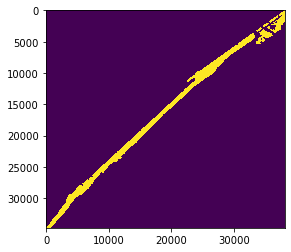

In [8]:
# check rotations using lidar DEM
fn = fdir+fnames[0]
da = xr.open_rasterio(fn)
plt.imshow(np.squeeze(da))


In [9]:
%%time

dslist=[]
for i in range(nf):
    fn = fdir+fnames[i]
    print(i, fn)
    
    # open the tif with XArray as a DataArray
    da = xr.open_rasterio(fn)
    
    print( np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values), np.shape( np.flipud(da.values)) )
    x = da['x'].values
    y = np.flipud(da['y'].values)
    
    # Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
    # However, make sure to squeeze before flipping
    z = np.flipud(np.squeeze(da.values))
    print(np.shape(x),np.shape(y),np.shape(z))
    

    if(smooth):
        # smooth with 2D running median
        zs = signal.medfilt2d(z, kernel_size=ksize)
    else:
        zs = z
    
    f = interpolate.RegularGridInterpolator( (y, x), zs, method='linear')   
    
    # Array for interpolated elevations
    zi=np.NaN*np.ones((ny,nx))

    # this is a slow iteration through all of the points, but allows us to skip ones that are outside
    for ij in np.ndindex(zi.shape):
        try:
            zi[ij]=f((yu[ij],xu[ij]))
        except:
            zi[ij]=np.NaN
            
    da = xr.DataArray(zi,dims=['Alongshore','Cross-shore'],coords={'Alongshore': ycoords, 'Cross-shore':xcoords })
    # dslist.append(da.chunk()) # this does not work...can't concatenate a method
    da = da.chunk()
    dslist.append(da)

dsa = xr.concat(dslist, dim='map')

0 D:/crs/proj/2019_DorianOBX/WayneWright_flights/post_Matthew_lidar_1m.tif
(34727,) (38113,) (1, 34727, 38113)
(38113,) (34727,) (34727, 38113)
1 D:/crs/proj/2019_DorianOBX/WayneWright_flights/2019-08-30_1m_DEM_v1_crop.tif
(22393,) (25165,) (1, 22393, 25165)
(25165,) (22393,) (22393, 25165)
2 D:/crs/proj/2019_DorianOBX/WayneWright_flights/2019-09-12-13_DEM_1m_v1_crop.tif
(22101,) (25420,) (1, 22101, 25420)
(25420,) (22101,) (22101, 25420)
Wall time: 5min 37s


In [10]:
print(np.shape(dsa.values))
dsa.load()

(3, 500, 1800)


<xarray.DataArray (map: 3, Alongshore: 500, Cross-shore: 1800)>
array([[[-4.227842e-02, -5.834684e-02, ..., -2.518436e-01, -2.483739e-01],
        [ 1.047269e-02,  9.393187e-04, ..., -2.341582e-01, -2.331109e-01],
        ...,
        [-8.080528e-01, -7.922446e-01, ...,  6.841041e-01,  7.342958e-01],
        [-7.690433e-01, -7.712837e-01, ...,  6.510642e-01,  7.467786e-01]],

       [[-3.276700e+04, -3.276700e+04, ..., -3.276700e+04, -3.276700e+04],
        [-3.276700e+04, -3.276700e+04, ..., -3.276700e+04, -3.276700e+04],
        ...,
        [-1.951562e+00, -3.067698e+00, ...,  8.911451e-01,  9.323287e-01],
        [-1.597911e+00, -1.756603e+00, ...,  8.895140e-01,  9.267743e-01]],

       [[-3.276700e+04, -3.276700e+04, ..., -3.276700e+04, -3.276700e+04],
        [-3.276700e+04, -3.276700e+04, ..., -3.276700e+04, -3.276700e+04],
        ...,
        [-3.276700e+04, -3.276700e+04, ...,  9.607549e-01,  1.000771e+00],
        [-3.276700e+04, -3.276700e+04, ...,  9.352032e-01,  9.723469

In [11]:
map_stats(dsa)

mean [    1.65046052 -1254.27634549 -1242.7599263 ]
mad [   1.71191964 1258.13449809 1246.00916411]
min [-1.47623482e+00 -3.27670000e+04 -3.27670000e+04]
max [ 6.60924107  8.25695002 11.67303086]
rms [1.96056426e+00 6.38271248e+03 6.34748506e+03]


(array([    1.65046052, -1254.27634549, -1242.7599263 ]),
 array([   1.71191964, 1258.13449809, 1246.00916411]))

In [12]:
### Adjust pre-Dorian map: lower by 17 cm.

In [13]:
dsaa = dsa.copy()
dsaa[1,:,:] = dsaa[1,:,:] - 0.17

dsaa = dsaa.where(dsaa>=0.4)
map_stats(dsaa)

mean [1.87709967 1.99048678 1.86858168]
mad [1.87709967 1.99048678 1.86858168]
min [0.40000408 0.40000307 0.40000465]
max [ 6.60924107  8.08695002 11.67303086]
rms [2.07036986 2.22880261 2.13918556]


(array([1.87709967, 1.99048678, 1.86858168]),
 array([1.87709967, 1.99048678, 1.86858168]))

(3, 1800)


C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\IOOS\lib\site-packages\xarray\core\nputils.py:220: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwds)


Text(0, 0.5, 'Dune Crest Elevaton (m)')

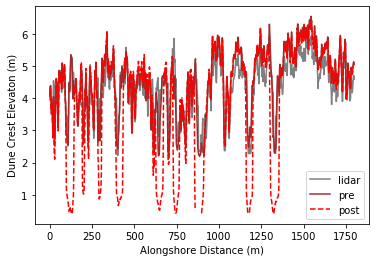

In [14]:
# calculate dhi
dhi = dsaa[:,0:100,:].max(axis=1,skipna=True)
print(np.shape(dhi))
plt.plot(dhi[0,:],color='gray',label='lidar')
plt.plot(dhi[1,:],color='brown',label='pre')
plt.plot(dhi[2,:],'--',color='red',label='post')
plt.legend()
plt.xlabel('Alongshore Distance (m)')
plt.ylabel('Dune Crest Elevaton (m)')

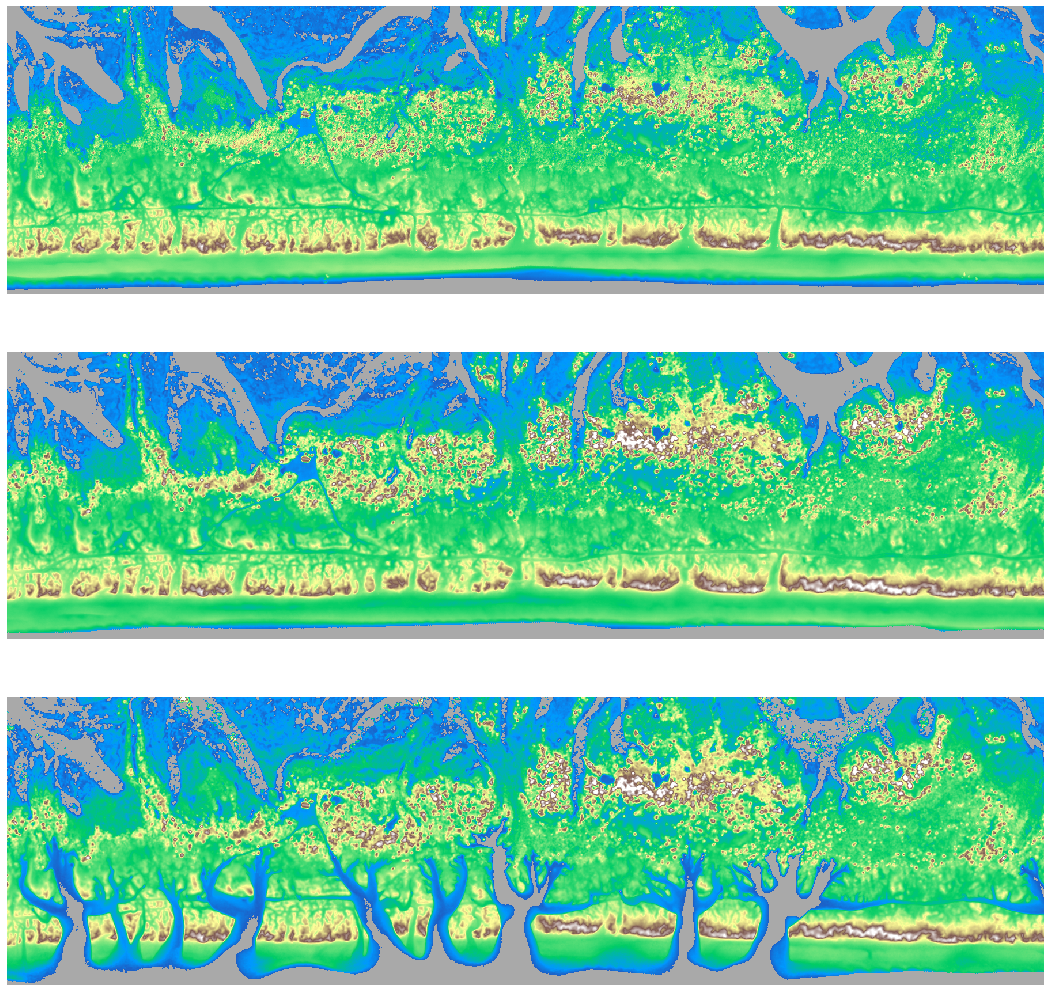

In [15]:
tcmap=plt.cm.terrain
tcmap.set_bad(color='darkgray')
plt.subplots(figsize=(24,18))
for i in range(nf):
    # small plots of elevation
    plt.subplot(3,1,i+1); plt.axis('off'); plt.imshow(np.flipud(dsaa[i,:,:]),cmap=tcmap,vmin=0,vmax=6)


(2, 500, 1800)
(2, 1800)


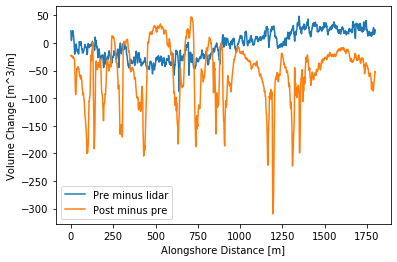

In [16]:
# calculate difference maps
xs_start = 0
xs_end = 250
xs_len = (xs_end-xs_start)*dxy
diffmap = np.diff(dsaa,axis=0)
print(np.shape(diffmap))
dv = np.nansum(diffmap[:,0:250,:],axis=1)
print(np.shape(dv))
plt.plot(dv[0,:],label='Pre minus lidar')
plt.plot(dv[1,:],label='Post minus pre')
plt.xlabel('Alongshore Distance [m]')
plt.ylabel('Volume Change [m^3/m]')
plt.legend()

In [17]:
print("Average volume changes: ",np.mean(dv,1)," [m3/m]")
print("Average elevation changes: ",np.mean(dv,1)/xs_len,"[m]")

Average volume changes:  [ -3.20492844 -53.14409188]  [m3/m]
Average elevation changes:  [-0.01281971 -0.21257637] [m]


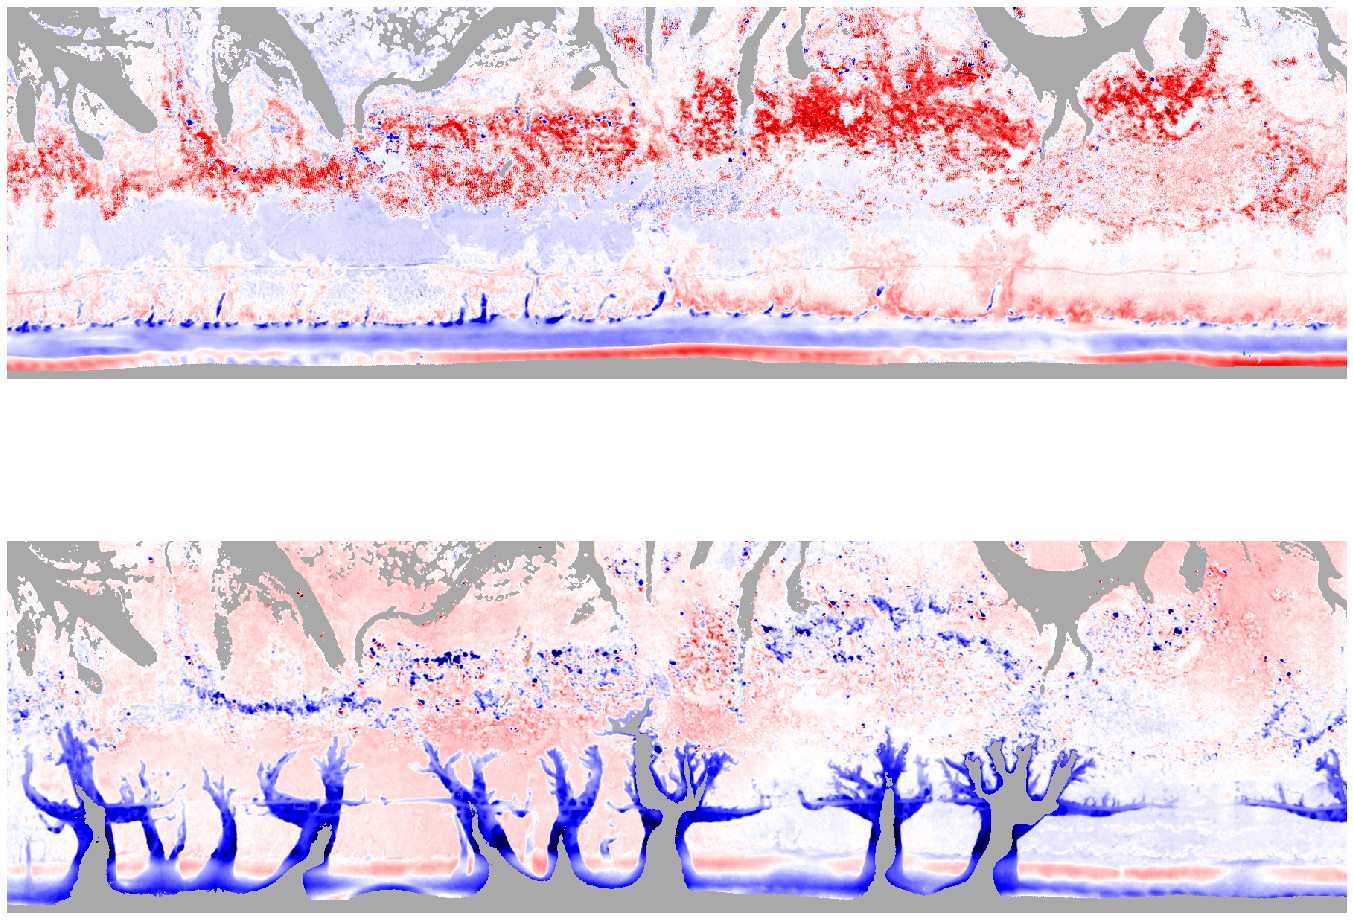

In [18]:
# plot diff maps
dcmap=plt.cm.seismic
dcmap.set_bad(color='darkgray')
fig, ax = plt.subplots(figsize=(24,18))
for i in range(2):
    # small plots of elevation
    plt.subplot(2,1,i+1); plt.axis('off'); plt.imshow(np.flipud(diffmap[i,:,:]),cmap=dcmap,vmin=-3,vmax=3.)